# Feature Importance vs PCA

Já sabendo que o classificador a ser usado na Raspberry será o SVM-SGD, esse Jupyter fará uma varredura na dimensionalidade para verificar qual é a melhor acurácia do SESA com cada dimensão.

Ainda vamos comparar a redução de dimensionalidade com a redução por Feature Importance. As features menos importantes serão descartadas.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

In [12]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [10, 5], 
    'axes.labelsize': 18,
    'axes.titlesize':20, 
    'font.size': 18,
    'legend.fontsize': 14, 
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

### Parâmetros Iniciais

In [3]:
# CSV COM AS FEATURES
caminhoCSV = "/home/dimi/Downloads/datasets/SESA_v2_16kHz_16bits/original/1593468747.7548976.csv"

# RESULTADO DO GRIDSEARCH DO SESA COM SGD
# VOU DEIXAR O N JOBS DO CLASSIFICADOR COM 1 POIS VAMOS USAR PARALELISMO EM OUTRA PARTE
classificador = "SGDClassifier(alpha=0.0001, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=1, penalty='l2', power_t=0.5, random_state=None, shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"

# QTD DE ITERACOES DO K FOLD    
qtdFoders=5

# ORDEM DAS FEATURES NO CSV
colunas = ["RMS", "CentroideEspectral", "LarguraBanda", "Planicidade", "Rolloff", "ZCR", "MFCC0", "MFCC1", "MFCC2", "MFCC3", "MFCC4", "MFCC5", "MFCC6", "MFCC7", "MFCC8", "MFCC9", "MFCC10", "MFCC11", "MFCC12", "MFCC13", "MFCC14", "MFCC15", "MFCC16", "MFCC17", "MFCC18", "MFCC19", "Delta0", "Delta1", "Delta2", "Delta3", "Delta4", "Delta5", "Delta6", "Delta7", "Delta8", "Delta9", "Delta10", "Delta11", "Delta12", "Delta13", "Delta14", "Delta15", "Delta16", "Delta17", "Delta18", "Delta19", "DeltaDelta0", "DeltaDelta1", "DeltaDelta2", "DeltaDelta3", "DeltaDelta4", "DeltaDelta5", "DeltaDelta6", "DeltaDelta7", "DeltaDelta8", "DeltaDelta9", "DeltaDelta10", "DeltaDelta11", "DeltaDelta12", "DeltaDelta13", "DeltaDelta14", "DeltaDelta15", "DeltaDelta16", "DeltaDelta17", "DeltaDelta18", "DeltaDelta19", "MelSpectro0", "MelSpectro1", "MelSpectro2", "MelSpectro3", "MelSpectro4", "MelSpectro5", "MelSpectro6", "MelSpectro7", "MelSpectro8", "MelSpectro9", "MelSpectro10", "MelSpectro11", "MelSpectro12", "MelSpectro13", "MelSpectro14", "MelSpectro15", "MelSpectro16", "MelSpectro17", "MelSpectro18", "MelSpectro19", "Cromagrama0", "Cromagrama1", "Cromagrama2", "Cromagrama3", "Cromagrama4", "Cromagrama5", "Cromagrama6", "Cromagrama7", "Cromagrama8", "Cromagrama9", "Cromagrama10", "Cromagrama11", "CromagramaQ0", "CromagramaQ1", "CromagramaQ2", "CromagramaQ3", "CromagramaQ4", "CromagramaQ5", "CromagramaQ6", "CromagramaQ7", "CromagramaQ8", "CromagramaQ9", "CromagramaQ10", "CromagramaQ11", "CromaCENS0", "CromaCENS1", "CromaCENS2", "CromaCENS3", "CromaCENS4", "CromaCENS5", "CromaCENS6", "CromaCENS7", "CromaCENS8", "CromaCENS9", "CromaCENS10", "CromaCENS11", "Tonntez0", "Tonntez1", "Tonntez2", "Tonntez3", "Tonntez4", "Tonntez5", "Contraste0", "Contraste1", "Contraste2", "Contraste3", "Contraste4", "Contraste5", "Contraste6"]

### Definição de função

A função abaixo recebe o caminho para o CSV do dataset e separa o dataset para uma única iteração de um K Fold. O parâmetro "pasta" determina qual será a pasta destinada para teste, o restante será treinamento.

In [4]:
def ajustarDataset(caminhoCSV, pasta):
    
    # ABRINDO
    dataframe = pd.read_csv(caminhoCSV)  
    
    # SEPARANDO DATA, TARGET E O NOME DOS ARQUIVOS
    data     = dataframe.iloc[:, 1:-1].to_numpy()
    target   = dataframe.iloc[:, -1].to_numpy()
    arquivos = dataframe.iloc[:, 0].to_numpy()
    
    # LIMPANDO A MEMORIA
    del dataframe
    
    # SEPARANTE TREINO E TESTE PELO NOME DO ARQUIVO (O ULTIMO NUMERO NO NOME E A PASTA casual_000_1.wav)
    xTrain, xTest, yTrain, yTest = [], [], [], []
    for xAtual, yAtual, arquivoAtual in zip(data, target, arquivos):
        
        # SE FOR DA PASTA ESCOLHIDA VAI PRO TESTE
        if int(arquivoAtual.split("_")[2][0]) == pasta:
            xTest.append(xAtual)
            yTest.append(yAtual)
        
        # SENAO VAI PRO TREINAMENTO
        else:
            xTrain.append(xAtual)
            yTrain.append(yAtual)
            
    # PASSANDO TUDO PRA NUMPY
    xTrain = np.array(xTrain)
    xTest  = np.array(xTest)
    yTrain = np.array(yTrain)
    yTest  = np.array(yTest)
            
    # VERIFICANDO A DIMENSIONALIDADE
    assert xTrain.shape[0] + xTest.shape[0] == data.shape[0], "Dimensionalidade dos Xs não bate."
    assert yTrain.shape[0] + yTest.shape[0] == target.shape[0], "Dimensionalidade dos Ys não bate."
    assert xTrain.shape[1] == xTest.shape[1] and xTest.shape[1] == data.shape[1], "Número de features não bate."
    
    # VAMO QUE VAMO
    return xTrain, xTest, yTrain, yTest

A função abaixo aplica o PCA nas matrizes xTrain e xTest.

In [5]:
def aplicarPCA(xTrain, xTest, qtdDimensoes):
    
    objPCA    = PCA(n_components=qtdDimensoes).fit(xTrain)
    xTrainPCA = objPCA.transform(xTrain)
    xTestPCA  = objPCA.transform(xTest)
    
    del objPCA
    assert xTrainPCA.shape[1] == qtdDimensoes and xTestPCA.shape[1] == qtdDimensoes, "Erro na função do PCA."
    
    return xTrainPCA, xTestPCA

A função abaixo realiza uma iteração do K Fold. Recebe os dados de treinamento e teste e retorna a acurácia.

In [36]:
def treinarEClassificar(xTrain, xTest, yTrain, yTest, classificador):
    
    # INSTANCIANDO O CLASSIFICADOR
    objClassificador = SGDClassifier(alpha=0.0001, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=1, penalty='l2', power_t=0.5, random_state=None, shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)
    #objClassificador = eval(classificador)
    
    # TREINANDO
    objClassificador.fit(xTrain, yTrain)
    
    # PREDIZENDO
    yPred = objClassificador.predict(xTest)
    
    # RETORNANDO A ACURACIA
    return accuracy_score(yTest, yPred)

A função abaixo usa as duas funções anteriores para aplicar o PCA e, em seguida, treinae e testae o classificador para retornar a acurácia e desvio padrao das classificacoes do K Fold.

In [7]:
def main(caminhoCSV, qtdFoders, qtdDimensoes, classificador):
    
    arrayAcuracias = []
    
    # PARA CADA PASTA (ITERACOES DO K FOLD)
    for pastaAtual in range(1, qtdFoders + 1):
        
        # SEPARO OS DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = ajustarDataset(caminhoCSV, pasta=pastaAtual)
        
        # APLICO O PCA COM A DIMENSIONALIDADE DESEJADA
        if qtdDimensoes != None:
            xTrain, xTest = aplicarPCA(xTrain, xTest, qtdDimensoes)
        
        # OBTENHO A CLASSIFCACAO E COLOCO NO ARRAY DE ACURACIAS
        arrayAcuracias.append(treinarEClassificar(xTrain, xTest, yTrain, yTest, classificador))        
        
    return arrayAcuracias

In [8]:
def plotar(rangeDimensoes, matrizAcuraciasReducoes, arrayAcuraciasReferencial, titulo, featureImportance=False):
    
    # MEDIA E DESVIO DO REFERENCIAL
    acuraciaMediaReferencial = np.mean(arrayAcuraciasReferencial)
    #desvioPadraoReferencial  = np.std(arrayAcuraciasReferencial)
    
    # MEDIA E DESVIO DA REDUCAO DE DIMENSIONALIDADE
    acuraciaMediaCadaDimensao = []
    desvioPadraoCadaDimensao  = []
    for acuraciasDimensaoAtual in matrizAcuraciasReducoes:
        acuraciaMediaCadaDimensao.append(np.mean(acuraciasDimensaoAtual))
        desvioPadraoCadaDimensao.append(np.std(acuraciasDimensaoAtual))
        
    if featureImportance == True:
        rangeDimensoes = np.arange(1,len(acuraciaMediaCadaDimensao)+1)
    
    # PLOT REFERENCIAL
    plt.plot(rangeDimensoes, np.full(len(acuraciaMediaCadaDimensao), acuraciaMediaReferencial), "--", color="black", label="Referencial")
    
    # PLOT REDUCAO DE DIMENSIONALIDADE
    plt.errorbar(rangeDimensoes, acuraciaMediaCadaDimensao, yerr=desvioPadraoCadaDimensao, label="Redução")
    
    # OUTROS PARAMETROS
    plt.title(titulo)
    plt.xlabel("Qtd de Dimensões")
    if featureImportance == True:
        plt.xlabel("Qtd de Features Dropadas")
    plt.ylabel("Acurácia")
    plt.grid(alpha=0.5)
    plt.legend()
    #plt.savefig(caminhoOndeSalvar, format='pdf', bbox_inches='tight')
    plt.show()

A função abaixo é a mesma ajustarDataset anterior, mas, dessa vez, ela também exclui algumas features do dataset. Essa função será usada na etapa de Feature Importance.

In [ ]:
def ajustarDatasetFeatureImportance(caminhoCSV, featuresOriginais, featuresDropar, pasta):

    # ABRINDO
    dataframe = pd.read_csv(caminhoCSV, names=["arquivo"] + featuresOriginais + ["classe"])

    # DROPANDO AS COLUNAS DESEJADAS
    dataframe = dataframe.drop(featuresDropar, axis=1)
    
    # SEPARANDO DATA, TARGET E O NOME DOS ARQUIVOS (DESSA VEZ TEM QUE PULAR A PRIMEIRA LINHA)
    data     = dataframe.iloc[1:, 1:-1].to_numpy()
    target   = dataframe.iloc[1:, -1].to_numpy()
    arquivos = dataframe.iloc[1:, 0].to_numpy()
    
    # LIMPANDO A MEMORIA
    del dataframe
    
    # SEPARANTE TREINO E TESTE PELO NOME DO ARQUIVO (O ULTIMO NUMERO NO NOME E A PASTA casual_000_1.wav)
    xTrain, xTest, yTrain, yTest = [], [], [], []
    for xAtual, yAtual, arquivoAtual in zip(data, target, arquivos):
        
        # SE FOR DA PASTA ESCOLHIDA VAI PRO TESTE
        if int(arquivoAtual.split("_")[2][0]) == pasta:
            xTest.append(xAtual)
            yTest.append(yAtual)
        
        # SENAO VAI PRO TREINAMENTO
        else:
            xTrain.append(xAtual)
            yTrain.append(yAtual)
            
    # PASSANDO TUDO PRA NUMPY
    xTrain = np.array(xTrain)
    xTest  = np.array(xTest)
    yTrain = np.array(yTrain)
    yTest  = np.array(yTest)
            
    # VERIFICANDO A DIMENSIONALIDADE
    assert xTrain.shape[0] + xTest.shape[0] == data.shape[0], "Dimensionalidade dos Xs não bate."
    assert yTrain.shape[0] + yTest.shape[0] == target.shape[0], "Dimensionalidade dos Ys não bate."
    assert xTrain.shape[1] == xTest.shape[1] and xTest.shape[1] == data.shape[1], "Número de features não bate."
    
    # VAMO QUE VAMO
    return xTrain, xTest, yTrain, yTest

A função abaixo é a mesma main de antes: vai rodar todas as iterações do K Fold e retornar um array de acurácias. Dessa vez, ao invés de mandar a dimensionalidade do PCA desejada, vamos mandar as features que queremos dropar, já que não tem PCA.

In [ ]:
def mainFeatureImportance(caminhoCSV, qtdFoders, featuresOriginais, featuresDropar, classificador):
    
    arrayAcuracias = []
    
    # PARA CADA PASTA (ITERACOES DO K FOLD)
    for pastaAtual in range(1, qtdFoders + 1):
        
        # SEPARO OS DADOS DE TREINAMENTO E TESTE JA COM AS FEATURES DROPADAS
        xTrain, xTest, yTrain, yTest = ajustarDatasetFeatureImportance(caminhoCSV, featuresOriginais, featuresDropar, pastaAtual)
        
        # OBTENHO A CLASSIFCACAO E COLOCO NO ARRAY DE ACURACIAS
        arrayAcuracias.append(treinarEClassificar(xTrain, xTest, yTrain, yTest, classificador))        
        
    return arrayAcuracias

## Acurácia em função da dimensionalidade do PCA

Vamos definir a matriz de acurácias como cada linha uma dimensionalidade, cada coluna uma iteração do K Fold. Antes de rodar as iteracões do PCA, vamos pegar a acurácia referencial (sem PCA).

In [ ]:
# ACURACIA REFENRECIAL
arrayAcuraciasReferencial = main(caminhoCSV, qtdFoders, None, classificador)

# ITERACOES DO PCA
qtdTotalFeatures   = 135
rangeDimensoes     = np.arange(1, qtdTotalFeatures)
matrizAcuraciasPCA = Parallel(n_jobs=-1, verbose=10)(delayed(main)(caminhoCSV, qtdFoders, qtdDimensoesAtual, classificador) for qtdDimensoesAtual in rangeDimensoes)

In [ ]:
plotar(rangeDimensoes, matrizAcuraciasPCA, arrayAcuraciasReferencial, "PCA")

**Dataset:** 

SESA v.2 original (sem data augmentation), amostragem de 16 kHZ, 16 bits de profundidade, janelamento de 200 ms, e com remoção de silêncio. 135 features.

**Resultado:**

Observa-se que para o dataset descrito, o PCA maior ou igual a 45 dimensões já garante uma acurácia média acima de 80%. Entretanto, para manter a acurácia referencial, é necessário usar pelo menos 82 dimensões.

## Feature Importance (GINI)

Agora, vamos reduzir a dimensionalidade usando feature importance, removendo as features menos importantes. Vai ficar muito mais fácil mexer com isso usando pandas.

In [ ]:
# ORDEM DAS FEATURES NO CSV
colunas = ["RMS", "CentroideEspectral", "LarguraBanda", "Planicidade", "Rolloff", "ZCR", "MFCC0", "MFCC1", "MFCC2", "MFCC3", "MFCC4", "MFCC5", "MFCC6", "MFCC7", "MFCC8", "MFCC9", "MFCC10", "MFCC11", "MFCC12", "MFCC13", "MFCC14", "MFCC15", "MFCC16", "MFCC17", "MFCC18", "MFCC19", "Delta0", "Delta1", "Delta2", "Delta3", "Delta4", "Delta5", "Delta6", "Delta7", "Delta8", "Delta9", "Delta10", "Delta11", "Delta12", "Delta13", "Delta14", "Delta15", "Delta16", "Delta17", "Delta18", "Delta19", "DeltaDelta0", "DeltaDelta1", "DeltaDelta2", "DeltaDelta3", "DeltaDelta4", "DeltaDelta5", "DeltaDelta6", "DeltaDelta7", "DeltaDelta8", "DeltaDelta9", "DeltaDelta10", "DeltaDelta11", "DeltaDelta12", "DeltaDelta13", "DeltaDelta14", "DeltaDelta15", "DeltaDelta16", "DeltaDelta17", "DeltaDelta18", "DeltaDelta19", "MelSpectro0", "MelSpectro1", "MelSpectro2", "MelSpectro3", "MelSpectro4", "MelSpectro5", "MelSpectro6", "MelSpectro7", "MelSpectro8", "MelSpectro9", "MelSpectro10", "MelSpectro11", "MelSpectro12", "MelSpectro13", "MelSpectro14", "MelSpectro15", "MelSpectro16", "MelSpectro17", "MelSpectro18", "MelSpectro19", "Cromagrama0", "Cromagrama1", "Cromagrama2", "Cromagrama3", "Cromagrama4", "Cromagrama5", "Cromagrama6", "Cromagrama7", "Cromagrama8", "Cromagrama9", "Cromagrama10", "Cromagrama11", "CromagramaQ0", "CromagramaQ1", "CromagramaQ2", "CromagramaQ3", "CromagramaQ4", "CromagramaQ5", "CromagramaQ6", "CromagramaQ7", "CromagramaQ8", "CromagramaQ9", "CromagramaQ10", "CromagramaQ11", "CromaCENS0", "CromaCENS1", "CromaCENS2", "CromaCENS3", "CromaCENS4", "CromaCENS5", "CromaCENS6", "CromaCENS7", "CromaCENS8", "CromaCENS9", "CromaCENS10", "CromaCENS11", "Tonntez0", "Tonntez1", "Tonntez2", "Tonntez3", "Tonntez4", "Tonntez5", "Contraste0", "Contraste1", "Contraste2", "Contraste3", "Contraste4", "Contraste5", "Contraste6"]

# ABRINDO
dataframe = pd.read_csv(caminhoCSV, names=["arquivo"]+colunas+["classe"])  
    
# SEPARANDO DATA, TARGET E O NOME DOS ARQUIVOS
data   = dataframe.iloc[:, 1:-1].to_numpy()
target = dataframe.iloc[:, -1].to_numpy()

# PRINTANDO 
dataframe.head(5)

In [ ]:
del dataframe

# OBTENDO O VETOR DE IMPORTANCIA DAS FEATURES
objDT = DecisionTreeClassifier()
objDT.fit(data, target)
arrayImportancias = objDT.feature_importances_

# Ordenando da menos importante para a mais importante
arrayImportancias, colunasOrdenadas = zip(*sorted(zip(arrayImportancias, colunas)))

In [ ]:
params = {
    'figure.figsize': [10, 20], 
    'axes.labelsize': 18,
    'axes.titlesize':20, 
    'font.size': 18,
    'legend.fontsize': 14, 
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

plt.barh(colunasOrdenadas, arrayImportancias)
#plt.xticks(rotation=90)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
matrizAcuraciasFeatureImportance = Parallel(n_jobs=-1, verbose=10)(delayed(mainFeatureImportance)(caminhoCSV, qtdFoders, colunas, list(colunasOrdenadas[0:i+1]), classificador) for i in range(qtdTotalFeatures-1))

In [ ]:
params = {
    'figure.figsize': [12, 6], 
    'axes.labelsize': 18,
    'axes.titlesize':20, 
    'font.size': 18,
    'legend.fontsize': 14, 
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

plotar(rangeDimensoes, matrizAcuraciasFeatureImportance, arrayAcuraciasReferencial, "Feature Importance", featureImportance=True)

**Dataset:** 

SESA v.2 original (sem data augmentation), amostragem de 16 kHZ, 16 bits de profundidade, janelamento de 200 ms, e com remoção de silêncio. 135 features.

**Resultado:**

Observa-se que para o dataset descrito, se removermos até 83 das features menos importantes, a acurácia se manteria maior ou igual à referencial.

Vamos observar quais features sobram quando removemos as 83 menos importantes:

In [ ]:
print(sorted(colunasOrdenadas[84:]))

E quais são as features que podem ser jogadas fora?

In [ ]:
print(sorted(colunasOrdenadas[:83]))

**Resultado:**

Não precisamos gastar tempo extrindo **Contraste, CromaCENS,** e **Tonnetz**, pois todas as posições dessas features não foram usadas e mesmo assim o classificador obteve o mesmo desempenho em acurácia. Além disso, as features **Delta, Delta Delta,** e **CromagramaQ** tiveram praticamente todas as suas posições não utilizadas, logo, podem ser descartadas também.

Portanto, vamos ficar apenas com: **MFCC, Mel Espectrograma, Cromagrama, Centróide Espectral, Largura de Banda, Planicidade, RMS, Rolloff,** e **ZCR**.

Vamos confirmar o resultado, novamente:

In [ ]:
colunasDropar = ["Delta0", "Delta1", "Delta2", "Delta3", "Delta4", "Delta5", "Delta6", "Delta7", "Delta8", "Delta9", "Delta10", "Delta11", "Delta12", "Delta13", "Delta14", "Delta15", "Delta16", "Delta17", "Delta18", "Delta19", "DeltaDelta0", "DeltaDelta1", "DeltaDelta2", "DeltaDelta3", "DeltaDelta4", "DeltaDelta5", "DeltaDelta6", "DeltaDelta7", "DeltaDelta8", "DeltaDelta9", "DeltaDelta10", "DeltaDelta11", "DeltaDelta12", "DeltaDelta13", "DeltaDelta14", "DeltaDelta15", "DeltaDelta16", "DeltaDelta17", "DeltaDelta18", "DeltaDelta19", "CromagramaQ0", "CromagramaQ1", "CromagramaQ2", "CromagramaQ3", "CromagramaQ4", "CromagramaQ5", "CromagramaQ6", "CromagramaQ7", "CromagramaQ8", "CromagramaQ9", "CromagramaQ10", "CromagramaQ11", "CromaCENS0", "CromaCENS1", "CromaCENS2", "CromaCENS3", "CromaCENS4", "CromaCENS5", "CromaCENS6", "CromaCENS7", "CromaCENS8", "CromaCENS9", "CromaCENS10", "CromaCENS11", "Tonntez0", "Tonntez1", "Tonntez2", "Tonntez3", "Tonntez4", "Tonntez5", "Contraste0", "Contraste1", "Contraste2", "Contraste3", "Contraste4", "Contraste5", "Contraste6"]
print("Features dropadas:", len(colunasDropar))
print("Features restantes:", qtdTotalFeatures - len(colunasDropar))

arrayAcuraciasConfirmacao = mainFeatureImportance(caminhoCSV, qtdFoders, featuresOriginais=colunas, featuresDropar=colunasDropar, classificador=classificador)

In [ ]:
print("Acurácia Referencial:", np.mean(arrayAcuraciasReferencial), "+-", np.std(arrayAcuraciasReferencial))
print("Acurácia Confirmação:", np.mean(arrayAcuraciasConfirmacao), "+-", np.std(arrayAcuraciasConfirmacao))

## Usando o resultado do Feature Importance para aplicar o PCA

Depois de verificar o resultado da etapa de Feature Importance acima, realizei uma nova extração de features, considerendo apenas as 58 destacadas. Agora, a ideia é ver se aplicar o PCA em cima dessas 58 pode reduzir ainda mais a dimensionalidade sem afetar a acurácia.

In [9]:
# CSV COM AS FEATURES
caminhoCSV = "/home/dimi/Downloads/datasets/SESA_v2_16kHz_16bits/original/1593543981.5068564_58features.csv"

In [10]:
# ACURACIA REFENRECIAL
arrayAcuraciasReferencial = main(caminhoCSV, qtdFoders, None, classificador)

# ITERACOES DO PCA
qtdTotalFeatures   = 58
rangeDimensoes     = np.arange(1, qtdTotalFeatures)
matrizAcuraciasPCA = Parallel(n_jobs=-1, verbose=10)(delayed(main)(caminhoCSV, qtdFoders, qtdDimensoesAtual, classificador) for qtdDimensoesAtual in rangeDimensoes)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  57 | elapsed:   13.2s remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   8 out of  57 | elapsed:   16.7s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  14 out of  57 | elapsed:   17.9s remaining:   55.0s
[Parallel(n_jobs=-1)]: Done  20 out of  57 | elapsed:   19.5s remaining:   36.0s
[Parallel(n_jobs=-1)]: Done  26 out of  57 | elapsed:   20.8s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  32 out of  57 | elapsed:   21.5s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  38 out of  57 | elapsed:   22.2s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  44 out of  57 | elapsed:   31.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  50 out of  57 | elapsed:   33.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   34.8s finished


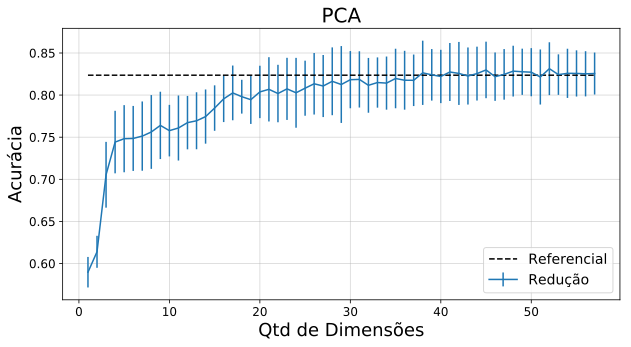

In [13]:
plotar(rangeDimensoes, matrizAcuraciasPCA, arrayAcuraciasReferencial, "PCA")

**Dataset:** 

SESA v.2 original (sem data augmentation), amostragem de 16 kHZ, 16 bits de profundidade, janelamento de 200 ms, e com remoção de silêncio. 58 features.

**Resultado:**

Utilizando apenas 58 features (de acordo com o resultado da etapa de Feature Importance), ainda seria possível aplicar o PCA com 38 componentes principais mantendo a acurácia referencial (sem PCA).

In [21]:
np.mean(matrizAcuraciasPCA[37])

print("Acurácia Feature Importance (58D):", np.mean(arrayAcuraciasReferencial), "+-", np.std(arrayAcuraciasReferencial))
print("Acurácia com PCA (38D):", np.mean(matrizAcuraciasPCA[37]), "+-", np.std(matrizAcuraciasPCA[37]))

Acurácia Feature Importance (58D): 0.8236413833583427 +- 0.025176691077974565
Acurácia com PCA (38D): 0.8264490222410119 +- 0.03814324133698723


## Teste de velocidade de processamento - Servidora do LAB

Vou bolar um teste para medir o custo computacional, porque só faz sentido aplicar o PCA se o **tempo de execução pra aplicar o PCA + tempo de classificação com 38 features** for menor que o **tempo de classificação com a dimensionalidade original**.

A função abaixo vai receber um objeto classificador já treinado com as dimensões corretas. Se for desejado, a função aplica o PCA nos dados de teste e depois classifica os dados. Um objeto PCA também deve ser enviado já "treinado". As únicas coisas que devem afetar o tempo de processamento são a aplicação do PCA e a predição dos dados de teste.

In [52]:
def medirTempoComESemPCA(xTest, objClassificador, objPCA):
    
    tempoInicio = time.time()
    
    if objPCA != None:
        xTest = objPCA.transform(xTest)
        
    __ = objClassificador.predict(xTest)
    
    tempoFim = time.time()
    
    return tempoFim - tempoInicio

Abaixo, vou criar os dois classificadores e treiná-los para que o tempo de processamento não inclua o treinamento. Também já vou deixar pronto um objeto PCA treinado, para que a aplicação do PCA nos dados de teste não inclua o "fit" do PCA, apenas o "transform".

In [67]:
# SELECIONANDO UMA UNICA ITERACAO DO K FOLD
xTrain, xTest, yTrain, __ = ajustarDataset(caminhoCSV, 1)

# TREINANDO UM CLASSIFICADOR COM TODAS AS DIMENSOES
objClassificadorSemPCA = SGDClassifier(alpha=0.0001, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=1, penalty='l2', power_t=0.5, random_state=None, shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)
objClassificadorSemPCA.fit(xTrain, yTrain)
print("objClassificadorSemPCA treinado com xTrain de", xTrain.shape)

# TREINANDO COM AS DIMENSOES REDUZIDAS
objPCA = PCA(n_components=38)
objPCA.fit(xTrain)
xTrain = objPCA.transform(xTrain)
objClassificadorComPCA = SGDClassifier(alpha=0.0001, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=1, penalty='l2', power_t=0.5, random_state=None, shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)
objClassificadorComPCA.fit(xTrain, yTrain)
print("objClassificadorComPCA treinado com xTrain de", xTrain.shape)

# LIMPANDO A MEMORIA POIS SO VOU PRECISAR DOS OBJETOS DOS CLASSIFICADORES JA TREINADOS, DO OBJ PCA E DO XTEST
del xTrain
del yTrain

objClassificadorSemPCA treinado com xTrain de (21902, 58)
objClassificadorComPCA treinado com xTrain de (21902, 38)


#### Rodando o experimento

In [68]:
# RODANDO SEM PCA
repetibilidade = 120
arrayTemposSemPCA = Parallel(n_jobs=-1, verbose=10)(delayed(medirTempoComESemPCA)(xTest, objClassificadorSemPCA, None) for i in range(repetibilidade))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  54 out of 120 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  67 out of 120 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of 120 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  93 out of 120 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 120 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


In [69]:
# RODANDO COM PCA
repetibilidade = 120
arrayTemposComPCA = Parallel(n_jobs=-1, verbose=10)(delayed(medirTempoComESemPCA)(xTest, objClassificadorComPCA, objPCA) for i in range(repetibilidade))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0205s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  54 out of 120 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  67 out of 120 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  80 out of 120 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  93 out of 120 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 120 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished


In [70]:
print("Tempo total médio sem PCA:", np.mean(arrayTemposSemPCA), "+-", np.std(arrayTemposSemPCA))
print("Tempo total médio com PCA:", np.mean(arrayTemposComPCA), "+-", np.std(arrayTemposComPCA))

Tempo total médio sem PCA: 0.002251005172729492 +- 0.0005577909513149635
Tempo total médio com PCA: 0.004084736108779907 +- 0.000670405992919316


**Resultado:**

Tempo total médio sem PCA: 0.002251005172729492 +- 0.0005577909513149635

Tempo total médio com PCA: 0.004084736108779907 +- 0.000670405992919316

**Considerações:**

O teste foi realizado na servidora do lab em que cada rodada considerou apenas o tempo para:

- Aplicar (ou não) o PCA
    
- Classificar todas as amostras de teste

Cada rodada usou apenas um núcleo do processador. O teste foi repetido 120x para os dois casos (com e sem PCA) para garantir veracidade. O treinamento dos classificadores e o treinamento do PCA não afetou o tempo medido pois essas etapas de "fit" foram feitas anteriormente. O cuidado foi para garantir que apenas o tempo da aplicação ou não do PCA + a classificação de novas amostras fosse medido.